# CSC420: Assignment 4

## Humzah Khan

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Question 4: Homography (60)

Choose Hallway Images

In [2]:
from google.colab import files

uploaded = files.upload()

Saving hallway1.jpg to hallway1.jpg
Saving hallway2.jpg to hallway2.jpg
Saving hallway3.jpg to hallway3.jpg


Load the Images + RGB -> Gray

In [4]:
# Load the hallway images for visualization
hallway1 = cv2.imread("hallway1.jpg")
hallway1_gray = cv2.cvtColor(hallway1, cv2.COLOR_BGR2GRAY)

hallway2 = cv2.imread("hallway2.jpg")
hallway2_gray = cv2.cvtColor(hallway2, cv2.COLOR_BGR2GRAY)

hallway3 = cv2.imread("hallway3.jpg")
hallway3_gray = cv2.cvtColor(hallway3, cv2.COLOR_BGR2GRAY)

Overlay the Points

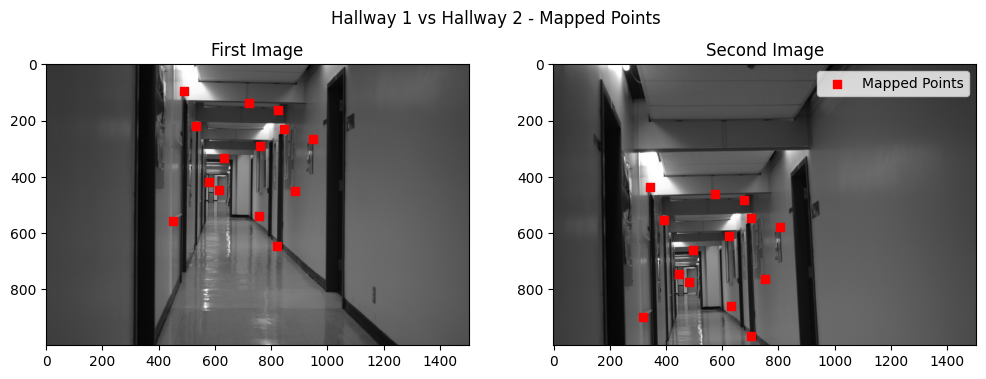

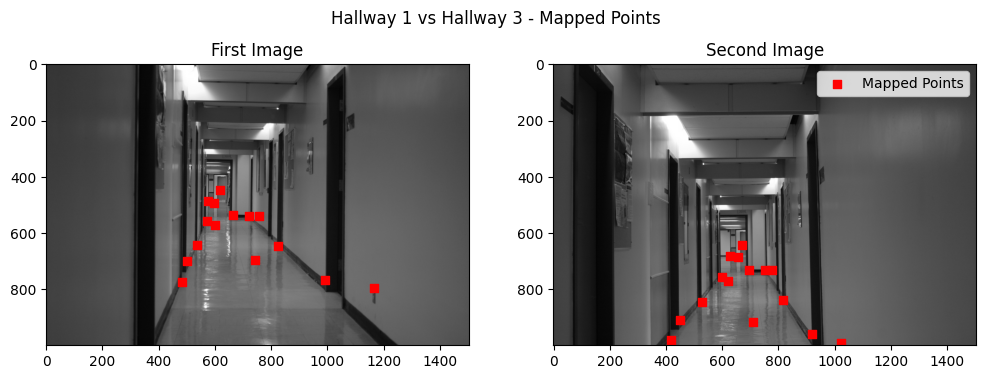

In [6]:
# Function to plot two images with corresponding points side by side
def plot_images_with_points(image1, points1, image2, points2, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot first image with points
    axes[0].imshow(image1, cmap="gray")
    axes[0].scatter(points1[:, 0], points1[:, 1], color='red', marker='s', label='Mapped Points')
    axes[0].set_title("First Image")
    #axes[0].axis("off")

    # Plot second image with points
    axes[1].imshow(image2, cmap="gray")
    axes[1].scatter(points2[:, 0], points2[:, 1], color='red', marker='s', label='Mapped Points')
    axes[1].set_title("Second Image")
    #axes[1].axis("off")

    fig.suptitle(title, y=0.82)
    plt.legend()
    plt.show()

# Example usage
#plot_images_with_points(hallway1_gray, points1, hallway2_gray, points2, "Hallway 1 vs Hallway 2 - Mapped Points")
#plot_images_with_points(hallway2_gray, points2, hallway3_gray, points3, "Hallway 2 vs Hallway 3 - Mapped Points")
#plot_images_with_points(hallway1_gray, points6, hallway3_gray, points7, "Hallway 1 vs Hallway 3 - Mapped Points")


Function to compute the Homography matrix

In [10]:
def compute_H(pointsA, pointsB, imageB_gray):
    # Construct the A matrix for solving H
    A = []
    for i in range(len(pointsA)):
        x, y = pointsA[i]
        x_prime, y_prime = pointsB[i]

        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    A = np.array(A)

    # Compute Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(A)

    # Last row of Vt gives the homography matrix
    H = Vt[-1].reshape(3, 3)

    # Normalize so that H[2,2] = 1
    H = H / H[2, 2]

    # Print the estimated homography matrix
    print("\nEstimated Homography Matrix:")
    print(H)

    # Describe the transformation effect
    scale_factor = np.linalg.norm(H[:2, :2], ord=2)
    rotation = np.arctan2(H[1, 0], H[0, 0])
    translation = H[:2, 2]
    shear = H[0, 1] / H[0, 0]

    print("\nHomography Effect:")
    print(f"Scale: {scale_factor:.4f}")
    print(f"Rotation (radians): {rotation:.4f}")
    print(f"Translation: {translation}")
    print(f"Shear: {shear:.4f}")

    # Transform the points using the estimated homography
    homogeneous_pts = np.hstack([pointsA, np.ones((pointsA.shape[0], 1))]).T
    mapped_pts = H @ homogeneous_pts
    mapped_pts /= mapped_pts[2]  # Normalize
    mapped_pts = mapped_pts[:2].T  # Convert back to 2D

    # Plot the original points and their mapped positions
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(imageB_gray, cmap="gray")
    ax.scatter(pointsB[:, 0], pointsB[:, 1], color="r", marker="s", label="Original Selected Points")
    ax.scatter(mapped_pts[:, 0], mapped_pts[:, 1], color="g", marker="s", label="Transformed Points")
    ax.legend()
    ax.set_title("Mapped Points using Homography")
    plt.show()


    return H

def stitch_images(imageA_gray, imageB_gray, H):
    # Define large enough output canvas
    offset_x, offset_y = 500, 500
    stitch_width = max(imageA_gray.shape[1], imageB_gray.shape[1]) + 2 * offset_x
    stitch_height = max(imageA_gray.shape[0], imageB_gray.shape[0]) + 2 * offset_y

    # Modify the homography matrix to apply the correct translation (Using H2 now)
    T_offset = np.array([
        [1, 0, offset_x],
        [0, 1, offset_y],
        [0, 0, 1]
    ])  # Translation matrix
    H_fixed = H  # Use H2 for warping image1 to image2
    H_final = T_offset @ H_fixed  # Apply translation correction

    # Warp hallway1 using fixed homography (for Blue & Green channels)
    warped_hallway1 = cv2.warpPerspective(imageA_gray, H_final, (stitch_width, stitch_height))

    # Create a blank RGB stitched image (initialized to black)
    stitched_rgb = np.zeros((stitch_height, stitch_width, 3), dtype=np.uint8)

    # **Insert hallway2 grayscale into the Blue & Green channel (Now Base Image)**
    stitched_rgb[offset_y:offset_y + imageB_gray.shape[0], offset_x:offset_x + imageB_gray.shape[1], 0] = imageB_gray  # Blue
    stitched_rgb[offset_y:offset_y + imageB_gray.shape[0], offset_x:offset_x + imageB_gray.shape[1], 1] = imageB_gray  # Green


    # Insert warped hallway1 grayscale into **Red channels**
    stitched_rgb[:, :, 2] = warped_hallway1  # Red
    #stitched_rgb[:, :, 1] = warped_hallway1  # Green

    # Display the final corrected RGB-stitched homography-mapped image
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(stitched_rgb, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Flipped Base: Image2 as Base, Image1 Warped")
    plt.show()

    return stitched_rgb

#H = compute_H(points1, points2, hallway2_gray)


Masking Code

In [72]:
def mask_and_show_right_wall_only(stitched_img, a, b, c=1, d=1):
    height, width = stitched_img.shape[:2]

    # Define the polygon between the lines (adjust points as needed)
    polygon = np.array([[
        (int(a * width), 0),          # Top-left of right region
        (int(c*width - 1), 0),                  # Top-right
        (int(d*width - 1), height - 1),         # Bottom-right
        (int(b * width), height - 1)  # Bottom-left of right region
    ]], dtype=np.int32)

    # Create mask
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, polygon, 255)

    # Apply the mask to all channels
    masked = cv2.bitwise_and(stitched_img, stitched_img, mask=mask)

    # # Show masked image
    # plt.figure(figsize=(10, 6))
    # plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.title('Masked Right Wall Region Only')
    # plt.show()

    return masked

def plot_masked(masked, title):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

## Q.4.1 Manually Chosen Points

In [77]:
# Given manually mapped points
points1 = np.array([
    [950, 264],  # p1 - top right small board
    [824, 161],  # p2 - light
    [634, 334],  # p3 - bottom edge of S
    [845, 230],  # p4 - top door edge
    [822, 645],  # p5 - left edge bottom close door
    [758, 538],  # p6 - top of outlet
    [884, 452],  # p7 - bottom right big board
    [762, 291],  # p8 - thick case top right front edge
    [451, 556],  # p9 - close stick face
    [489, 96],   # p10 - top door right
    [615, 448],  # p11 - doorknob
    [580, 417],  # p12 - flat sign
    [720, 136],  # p13 - middle beam
    [534, 221]   # p14 - right door top corner
], dtype=np.float32)

points2 = np.array([
    [806, 577],  # p1 - top right small board
    [677, 481],  # p2 - light
    [497, 660],  # p3 - bottom edge of S
    [702, 546],  # p4 - top door edge
    [701, 967],  # p5 - left edge bottom close door
    [631, 861],  # p6 - top of outlet
    [751, 764],  # p7 - bottom right big board
    [623, 610],  # p8 - thick case top right front edge
    [318, 900],  # p9 - close stick face
    [342, 435],  # p10 - top door right
    [481, 775],  # p11 - doorknob
    [445, 746],  # p12 - flat sign
    [574, 463],  # p13 - middle beam
    [392, 554]   # p14 - right door top corner
], dtype=np.float32)

points3 = np.array([
    [880, 453],  # p1 - top right small board _________
    [795, 355],  # p2 - light _________
    [663, 530],  # p3 - bottom edge of S
    [819, 421],  # p4 - top door edge
    [815, 839],  # p5 - left edge bottom close door _________
    [776, 733],  # p6 - top of outlet
    [847, 638],  # p7 - bottom right big board
    [768, 482],  # p8 - thick case top right front edge
    [348, 760],  # p9 - close stick face _________
    [410, 304],  # p10 - top door right _________
    [670, 641],  # p11 - doorknob
    [633, 613],  # p12 - flat sign
    [661, 335],  # p13 - middle beam
    [510, 424]   # p14 - right door top corner
], dtype=np.float32)

points4 = np.array([
    [950, 264],   # p1 - top right small board
    [824, 161],   # p2 - light
    [634, 334],   # p3 - bottom edge of S
    [845, 230],   # p4 - top door edge
    [822, 645],   # p5 - left edge bottom second door
    [758, 538],   # p6 - top of outlet
    [884, 452],   # p7 - bottom right big board
    [762, 291],   # p8 - thick case top right front edge
    [451, 556],   # p9 - close stick face
    [489, 96],    # p10 - top door right
    [615, 448],   # p11 - doorknob
    [580, 417],   # p12 - flat sign
    [720, 136],   # p13 - middle beam
    [534, 221],   # p14 - right door top corner
    [1170, 799],  # p15 - close outlet
    [743, 697],   # p16 - floor closer
    [601, 573],   # p17 - floor further
    [709, 65],    # p18 - ceiling higher
    [500, 698],   # p19 - bottom corner left close
    [306, 456],   # p20 - mid close closer
    [420, 448],   # p21 - mid close
    [430, 30],    # p22 - pin
    [992, 767],   # p23 - bottom corner right close
    [1064, 14],   # p24 - top right door closest
    [1170, 464],  # p25 - mid right close
    [1099, 230],  # p26 - bottom close square
    [1097, 179],  # p27 - top close square
    [664, 535]    # p28 - central entrance corner
], dtype=np.float32)

points5 = np.array([
    [880, 453],   # p1 - top right small board
    [795, 355],   # p2 - light
    [663, 530],   # p3 - bottom edge of S
    [819, 421],   # p4 - top door edge
    [815, 839],   # p5 - left edge bottom second door
    [776, 733],   # p6 - top of outlet
    [847, 638],   # p7 - bottom right big board
    [768, 482],   # p8 - thick case top right front edge
    [348, 760],   # p9 - close stick face
    [410, 304],   # p10 - top door right
    [670, 641],   # p11 - doorknob
    [633, 613],   # p12 - flat sign
    [661, 335],   # p13 - middle beam
    [510, 424],   # p14 - right door top corner
    [1028, 990],  # p15 - close outlet
    [710, 917],   # p16 - floor closer
    [620, 773],   # p17 - floor further
    [647, 267],   # p18 - ceiling higher
    [450, 908],   # p19 - bottom corner left close
    [60, 660],    # p20 - mid close closer
    [280, 659],   # p21 - mid close
    [283, 245],   # p22 - pin
    [920, 958],   # p23 - bottom corner right close
    [936, 204],   # p24 - top right door closest
    [1031, 660],  # p25 - mid right close
    [967, 416],   # p26 - bottom close square
    [963, 367],   # p27 - top close square
    [696, 732]    # p28 - central entrance corner
], dtype=np.float32)

points6 = np.array([
    [484, 775],
    [500, 700],
    [537, 648],
    [571, 558],
    [574, 487],
    [597, 493],
    [618, 447],
    [664, 537],
    [720, 538],
    [823, 645],
    [996, 762],
    [1171, 797],
    [600, 573],
    [748, 709],
    [757, 539],
    [713, 770],
    [572, 695]
], dtype=np.float32)

points7 = np.array([
    [418, 981],
    [451, 908],
    [528, 846],
    [600, 755],
    [629, 681],
    [655, 687],
    [671, 643],
    [696, 731],
    [753, 731],
    [816, 839],
    [920, 959],
    [1023, 993],
    [620, 772],
    [711, 916],
    [779,733],
    [652, 982],
    [536, 909]
], dtype=np.float32)


Define Best Chosen Points for the Three Cases

In [78]:
# Case A, Image 1 and 2
CaseA1_Points = points1
CaseA2_Points = points2

# Case B, Image 1 and 3
selected_indices = [0,1,2,3,4,5,6,7,10,11,12,14,15,16,17,22,23,24,25,26] # Right Wall Points
RW_points4 = points4[selected_indices]
RW_points5 = points5[selected_indices]
selected_indices = [3, 5, 7, 8, 15, 17, 19] # Best Subset Found

CaseB1_Points = RW_points4[selected_indices]
CaseB3_Points = RW_points5[selected_indices]

# Case C, Image 1 and 3
selected_indices = [1, 5, 8, 10, 13, 15] # Best Subset Found

CaseC1_Points = points6[selected_indices]
CaseC3_Points = points7[selected_indices]


Putting it All Together

In [81]:
def CaseSwitcher(case):
    # Defining Points and Images to use

    if case == "A":
        p_set1 = CaseA1_Points
        p_set2 = CaseA2_Points
        img2 = hallway2_gray
        img1 = hallway1_gray
        check = 0

    elif case == "B":
        p_set1 = CaseB1_Points
        p_set2 = CaseB3_Points
        img2 = hallway3_gray
        img1 = hallway1_gray
        check = 1

    elif case == "C":
        p_set1 = CaseC1_Points
        p_set2 = CaseC3_Points
        img2 = hallway3_gray
        img1 = hallway1_gray
        check = 1

    else:
        raise ValueError("Invalid case. Choose 'A', 'B', or 'C'.")

    # Q.4.1 - Plotting the Points on the Gray Images
    if check == 0:
      plot_images_with_points(img1, p_set1, img2, p_set1, "Hallway 1 vs Hallway 2 - Mapped Points")
    else:
      plot_images_with_points(img1, p_set1, img2, p_set2, "Hallway 1 vs Hallway 3 - Mapped Points")

    # Q.4.2 - Estimating H
    # Q.4.3 - Plot Transformed Points
    H = compute_H(p_set1, p_set2, img2)

    # Q.4.4 - RGB Stitching
    image = stitch_images(img1, img2, H)


    if case == "A":
        masked_image = mask_and_show_right_wall_only(image, -0.1,0.67)
        masked_image = mask_and_show_right_wall_only(masked_image, 0.75,0.16)
        plot_masked(masked_image, "Masked Right Wall Region Image 1 -> 2")
        return

    elif case == "B":
        masked_image = mask_and_show_right_wall_only(image, 0.12,0.69)
        masked_image = mask_and_show_right_wall_only(masked_image, 0.74,0.24)
        plot_masked(masked_image, "Masked Right Wall Region Image 1 -> 3")
        return

    elif case == "C":
        masked_image = mask_and_show_right_wall_only(image, 0.83,0.18)
        masked_image = mask_and_show_right_wall_only(masked_image, 0,0,0.2,0.7)
        plot_masked(masked_image, "Masked Floor Region Image 1 -> 3")
        return

    return


Case A

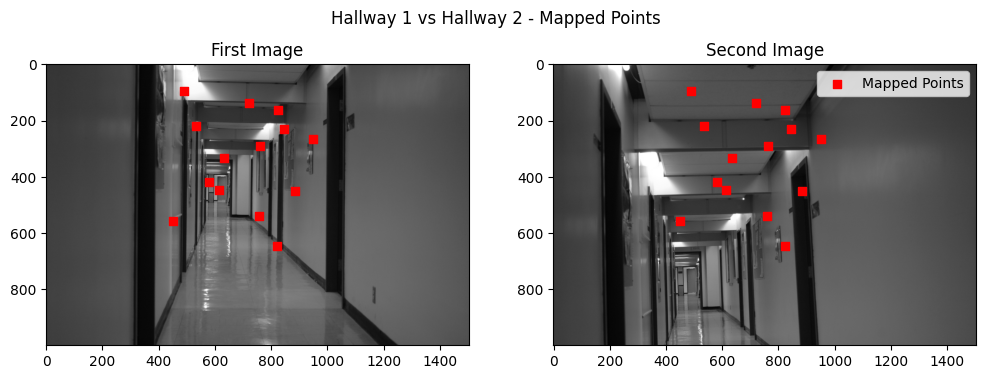


Estimated Homography Matrix:
[[ 1.02344667e+00 -1.17092773e-03 -1.52903002e+02]
 [-2.84728341e-02  9.42650669e-01  3.62635315e+02]
 [ 4.01071323e-05 -8.18310252e-05  1.00000000e+00]]

Homography Effect:
Scale: 1.0262
Rotation (radians): -0.0278
Translation: [-152.90300191  362.63531474]
Shear: -0.0011


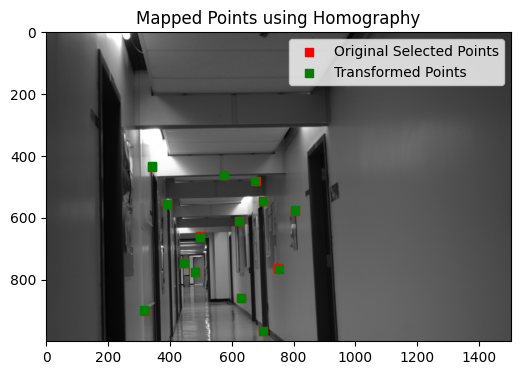

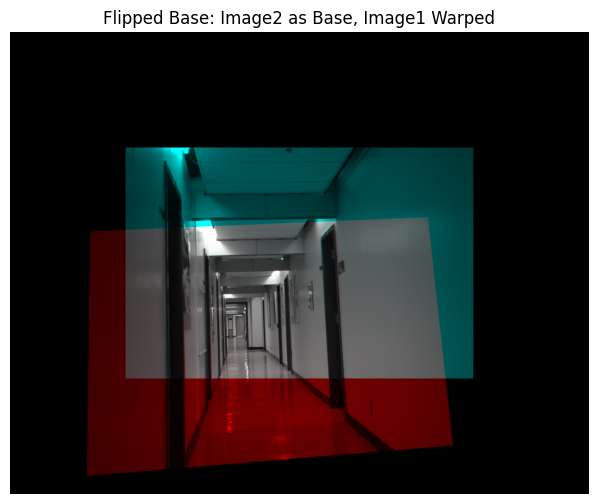

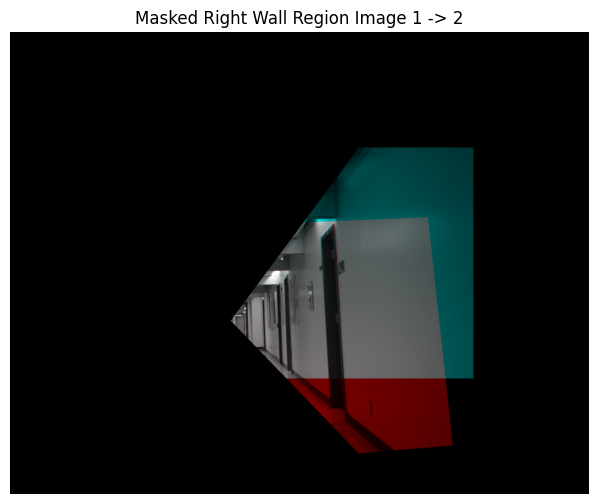

In [82]:
case = "A"
CaseSwitcher(case)

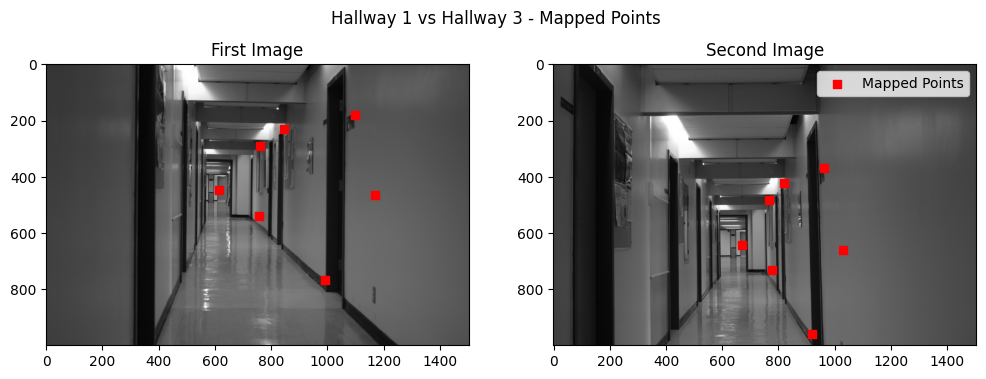


Estimated Homography Matrix:
[[ 4.76316915e-01  1.09482258e-02  3.35429320e+02]
 [-6.53946107e-02  8.86416828e-01  2.37746048e+02]
 [-1.00826534e-04 -1.85694106e-05  1.00000000e+00]]

Homography Effect:
Scale: 0.8893
Rotation (radians): -0.1364
Translation: [335.42931981 237.74604767]
Shear: 0.0230


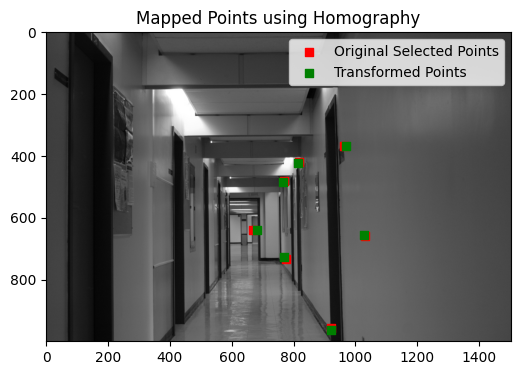

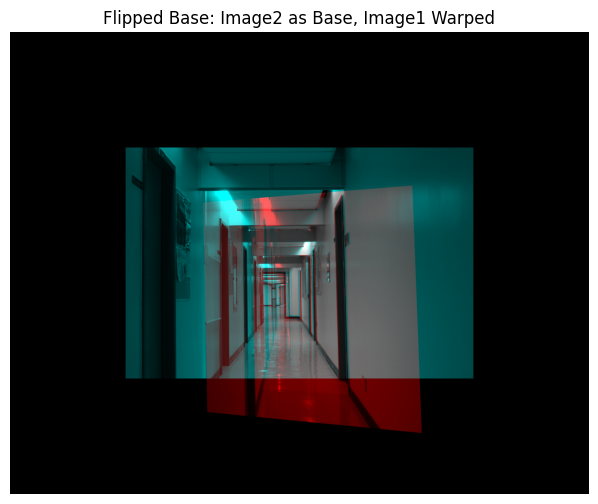

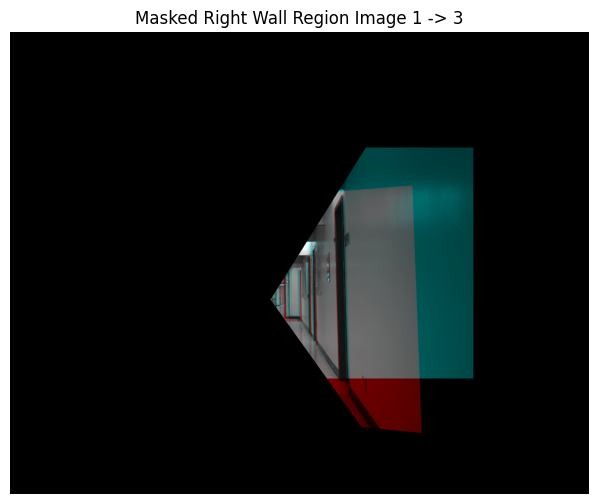

In [83]:
case = "B"
CaseSwitcher(case)

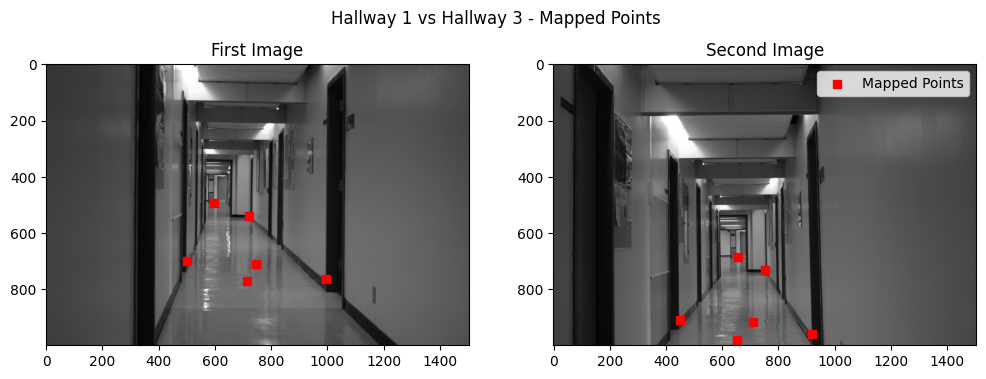


Estimated Homography Matrix:
[[ 1.08901820e+00 -7.06840479e-01  3.19576212e+02]
 [ 2.50373559e-01  5.67439001e-01  2.20345059e+02]
 [ 3.07815361e-04 -4.81025179e-04  1.00000000e+00]]

Homography Effect:
Scale: 1.3031
Rotation (radians): 0.2260
Translation: [319.57621177 220.34505904]
Shear: -0.6491


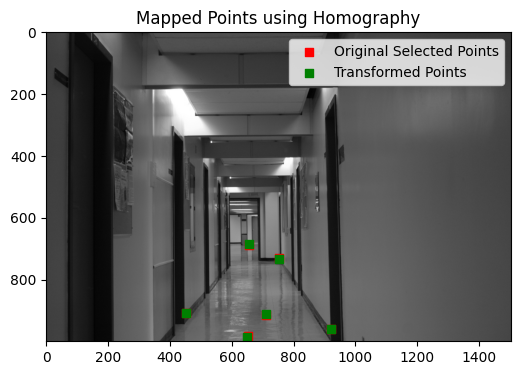

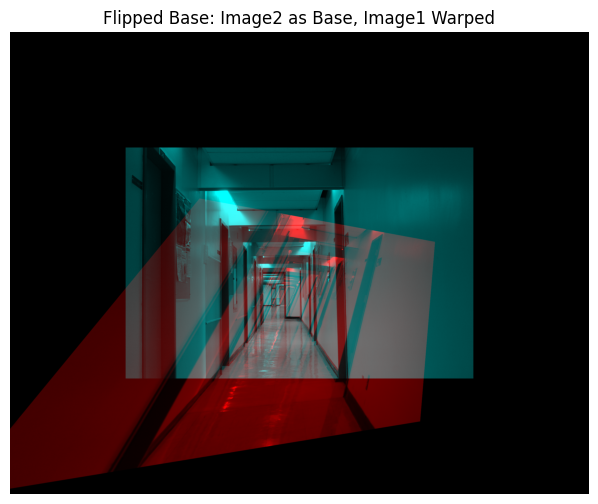

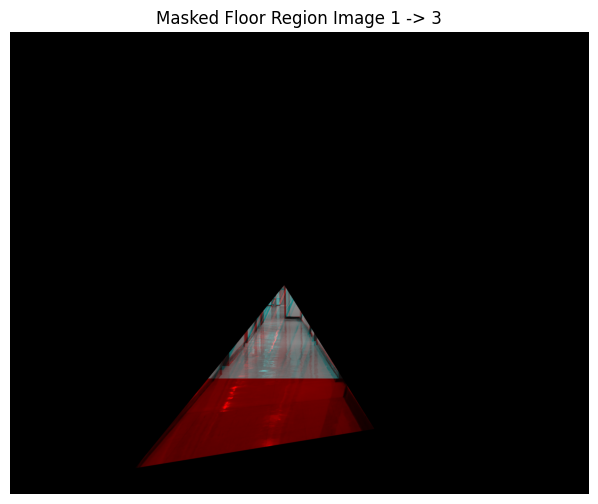

In [84]:
case = "C"
CaseSwitcher(case)

## Question 5: Mean Shift Tracking

Upload Mbappe Video

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving KylianMbappe.mp4 to KylianMbappe (1).mp4


Detect face in the first frame with Viola-Jones

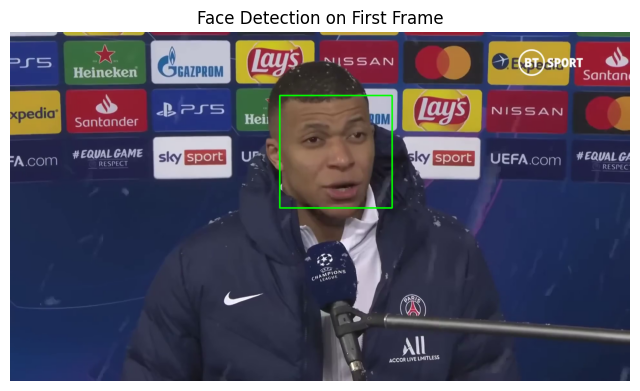

In [ ]:
# Load the Haar Cascade for face detection (Viola-Jones algorithm)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the video
video_path = "KylianMbappe.mp4"
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()
cap.release()  # Close the video capture

if ret:
    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    # Draw bounding boxes around detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Green box

    # Convert BGR to RGB for displaying in Matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the result
    plt.figure(figsize=(8, 6))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title("Face Detection on First Frame")
    plt.show()
else:
    print("Error: Could not read video file.")


Create histogram

In [ ]:
# Convert frame to HSV
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# Extract the face region
(x, y, w, h) = faces[0]  # Use the first detected face
face_roi = hsv_frame[y:y+h, x:x+w]

# Create a mask based on saturation and value thresholds
lower_bound = np.array([0, 60, 32])  # Low saturation & value are ignored
upper_bound = np.array([180, 255, 255])
mask = cv2.inRange(face_roi, lower_bound, upper_bound)

# Compute the Hue Histogram
hist = cv2.calcHist([face_roi], [0], mask, [180], [0, 180])
cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)  # Normalize

# Save the tracking window
track_window = (x, y, w, h)


In [ ]:
# Reopen the video
cap = cv2.VideoCapture(video_path)

# Skip the first frame (since we already processed it)
ret, frame = cap.read()

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    # Convert frame to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Compute back projection using the Hue Histogram
    back_proj = cv2.calcBackProject([hsv_frame], [0], hist, [0, 180], 1)

    # Apply Mean Shift to find the new location
    ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))

    # Draw the tracking box
    x, y, w, h = track_window
    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue box for tracking

    # Convert BGR to RGB for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the tracking frame
    #plt.imshow(frame_rgb)
    #plt.axis("off")
    #plt.pause(0.03)  # Pause for smooth animation

cap.release()
#plt.show()


IoU with Viola-Jones

In [ ]:
def calculate_iou(boxA, boxB):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.

    Args:
    - boxA, boxB: (x, y, w, h) format

    Returns:
    - IoU score (float between 0 and 1)
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute intersection area
    intersection = max(0, xB - xA) * max(0, yB - yA)

    # Compute areas of both bounding boxes
    areaA = boxA[2] * boxA[3]
    areaB = boxB[2] * boxB[3]

    # Compute union
    union = areaA + areaB - intersection

    # Avoid division by zero
    if union == 0:
        return 0.0

    return intersection / union


In [ ]:
# Load Viola-Jones Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Reopen video
cap = cv2.VideoCapture(video_path)

# Skip the first frame (since we already processed it)
ret, frame = cap.read()

frame_count = 1  # Start from frame 1
iou_values = []  # Store IoU values
frame_numbers = []  # Store frame numbers

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    frame_count += 1  # Increment frame number

    # Convert frame to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Compute back projection using the Hue Histogram
    back_proj = cv2.calcBackProject([hsv_frame], [0], hist, [0, 180], 1)

    # Apply Mean Shift to update tracking
    ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))

    # Get bounding box from Mean Shift
    x, y, w, h = track_window

    # Convert frame to grayscale for Viola-Jones
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect face using Viola-Jones
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        detected_face = faces[0]  # Take the first detected face
        iou = calculate_iou(track_window, detected_face)
        iou_values.append(iou)
        frame_numbers.append(frame_count)

cap.release()


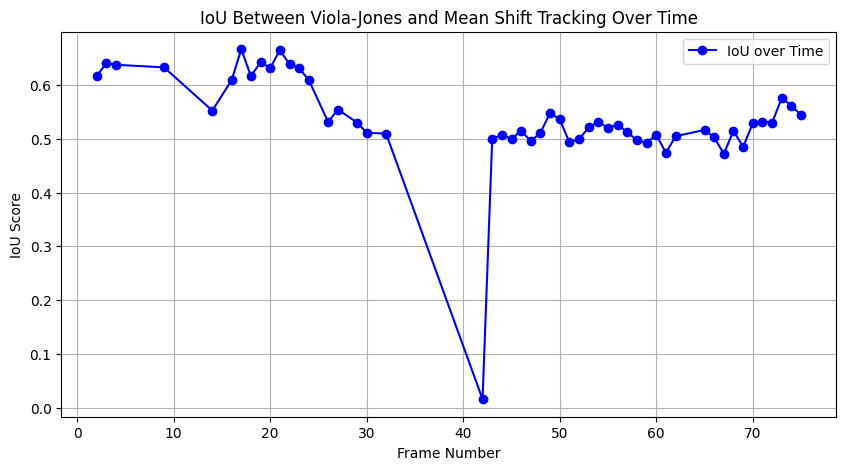

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(frame_numbers, iou_values, marker='o', linestyle='-', color='b', label="IoU over Time")
plt.xlabel("Frame Number")
plt.ylabel("IoU Score")
plt.title("IoU Between Viola-Jones and Mean Shift Tracking Over Time")
plt.legend()
plt.grid(True)
plt.show()


IoU Above 50% Match

In [ ]:
# Calculate the percentage of frames where IoU > 50%
iou_threshold = 0.5
num_frames_above_threshold = sum(1 for iou in iou_values if iou > iou_threshold)
total_frames = len(iou_values)

# Compute the percentage
percentage_above_threshold = (num_frames_above_threshold / 75) * 100

print(f"Percentage of frames where IoU > 50%: {percentage_above_threshold:.2f}%")


Percentage of frames where IoU > 50%: 53.33%


Frame 17 (above 50%) and Frame 42 (below 10%)

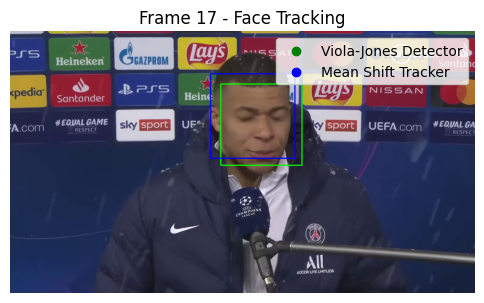

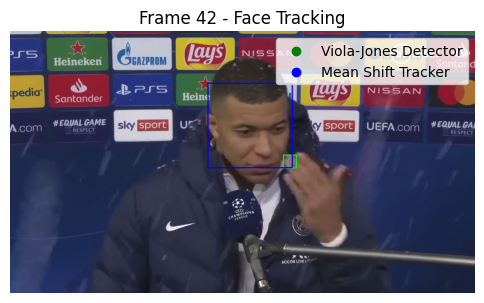

In [ ]:
# Reopen video
cap = cv2.VideoCapture(video_path)

# Define the target frames
target_frames = [17, 42]
frames_to_display = {}

frame_count = 1  # Start from frame 1

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    if frame_count in target_frames:
        # Convert to HSV for Mean Shift
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        back_proj = cv2.calcBackProject([hsv_frame], [0], hist, [0, 180], 1)
        ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))
        tracked_box = track_window  # (x, y, w, h)

        # Convert to grayscale for Viola-Jones
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

        if len(faces) > 0:
            detected_face = faces[0]  # Take the first detected face

            # Draw bounding boxes
            x, y, w, h = detected_face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Green (Viola-Jones)

            x, y, w, h = tracked_box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue (Mean Shift)

            # Store the frame
            frames_to_display[frame_count] = frame

    frame_count += 1

cap.release()

# Display frames 17 and 42
for frame_number in target_frames:
    if frame_number in frames_to_display:
        frame_rgb = cv2.cvtColor(frames_to_display[frame_number], cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(frame_rgb)
        plt.axis("off")
        plt.title(f"Frame {frame_number} - Face Tracking")

        # Create legend
        plt.scatter([], [], color='green', label="Viola-Jones Detector")
        plt.scatter([], [], color='blue', label="Mean Shift Tracker")
        plt.legend()

        plt.show()


### **Discussion**

The Mean Shift tracker appears to perform better than the Viola-Jones detector overall in the Mbappe video because following the color histogram, is making the object detection more resilient to occlusions and smoother over time. In contrast, Viola-Jones applies frame-by-frame detection, meaning it can misclassify background objects or transient features (like a hand or nail) as faces, leading to sudden errors. Mean Shift’s reliance on histogram back-projection appears to allow it to stay focused on the tracked object, even when part of the face is temporarily blocked. Assuming at least the first frame was correctly identifying the object to get it's histogram.

### A Simple Variation (Hog)

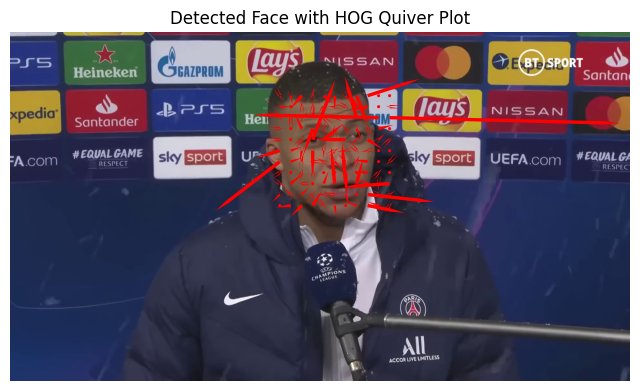

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if ret:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect face using Viola-Jones
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        x, y, w, h = faces[0]  # First detected face

        # Apply Gaussian Blur to reduce noise
        gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Compute image gradients using Sobel operator
        grad_x = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=3)

        # Convert gradients to magnitude & direction (in degrees)
        mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

        # Extract the face region
        face_roi_angle = angle[y:y+h, x:x+w]
        face_roi_mag = mag[y:y+h, x:x+w]

        # Compute max gradient magnitude inside face ROI
        max_mag = np.max(face_roi_mag)
        threshold = 0.02 * max_mag  # Threshold for keeping strong gradients
        mask = (face_roi_mag > threshold).astype(np.uint8)  # Create binary mask
        #mask = (mask < (1-threshold)).astype(np.uint8)

        # Downsample the grid for quiver plotting
        step = max(1, w // 10)  # Adjust step size for reasonable arrow density
        X, Y = np.meshgrid(np.arange(x, x + w, step), np.arange(y, y + h, step))

        # Extract gradient directions at sampled points
        sampled_angles = face_roi_angle[::step, ::step]
        sampled_mags = face_roi_mag[::step, ::step]

        # Convert angles to radians for quiver plotting
        U = np.cos(np.deg2rad(sampled_angles)) * sampled_mags
        V = np.sin(np.deg2rad(sampled_angles)) * sampled_mags

        # Normalize arrow sizes for better visibility
        scale_factor = h / 1000  # Scale arrows relative to face height
        U /= scale_factor
        V /= scale_factor

        # Convert frame to RGB for plotting
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Plot the face with gradient quiver arrows
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(frame_rgb)
        ax.axis("off")
        ax.set_title("Detected Face with HOG Quiver Plot")

        # Draw green bounding box around detected face
        cv2.rectangle(frame_rgb, (x, y), (x + w, y + h), (0, 255, 0), 3)

        # Overlay quiver plot inside the detected face
        ax.quiver(X, Y, U, V, color="red", angles="xy", scale_units="xy", scale=1, headlength=0, headwidth=0)

        plt.show()

    else:
        print("No face detected in the first frame.")

else:
    print("Error: Could not read video file.")


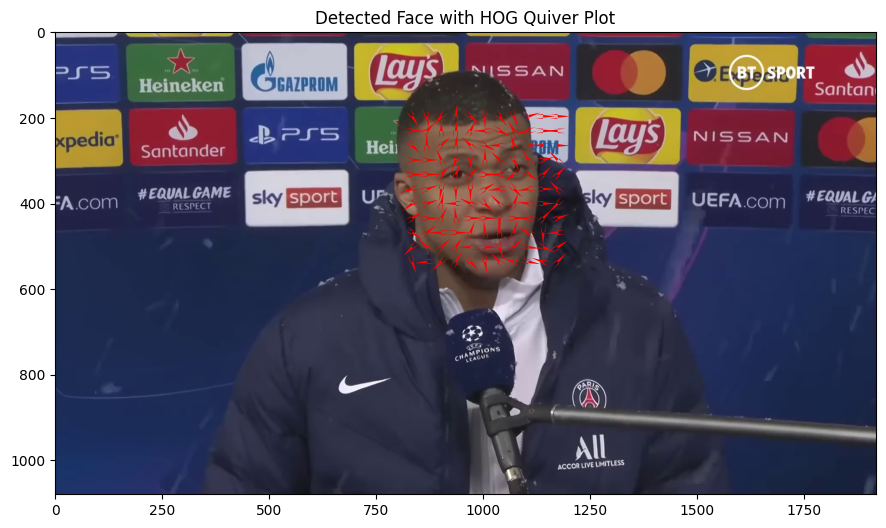

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if ret:
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect face using Viola-Jones
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        x, y, w, h = faces[0]  # First detected face

        # Apply Gaussian Blur to reduce noise
        gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Compute image gradients using Sobel operator
        grad_x = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=3)

        # Convert gradients to magnitude & direction (in degrees)
        mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

        # Extract the face region
        face_roi_angle = angle[y:y+h, x:x+w]
        face_roi_mag = mag[y:y+h, x:x+w]

        # Compute frequency-based histogram (no magnitude weighting)
        hist_bins = 24
        hist_range = [0, 360]
        hist = cv2.calcHist([face_roi_angle], [0], None, [hist_bins], hist_range)  # No mask, no magnitude weighting

        # Normalize histogram for better visualization
        hist = hist / np.sum(hist)  # Normalize to sum to 1

        # Downsample the grid for quiver plotting
        step = max(1, w // 10)  # Adjust step size for reasonable arrow density
        X, Y = np.meshgrid(np.arange(x, x + w, step), np.arange(y, y + h, step))

        # Extract gradient directions at sampled points
        sampled_angles = face_roi_angle[::step, ::step]
        sampled_mags = face_roi_mag[::step, ::step]

        # Convert angles to radians for quiver plotting
        U = np.cos(np.deg2rad(sampled_angles))
        V = np.sin(np.deg2rad(sampled_angles))

        # Normalize arrow sizes for better visibility
        scale_factor = h / 10000  # Adjust scaling to make arrows visible
        U /= scale_factor
        V /= scale_factor

        # Convert frame to RGB for plotting
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Create figure with two subplots (face detection + histogram)
        fig, ax = plt.subplots( figsize=(12, 6))

        # Show the face with detected bounding box and quiver arrows
        ax.imshow(frame_rgb)
        #ax[0].axis("off")
        ax.set_title("Detected Face with HOG Quiver Plot")

        # Draw green bounding box around detected face
        cv2.rectangle(frame_rgb, (x, y), (x + w, y + h), (0, 255, 0), 3)

        # Overlay quiver plot inside the detected face
        ax.quiver(X, Y, U, V, color="red", angles="xy", scale_units="xy", scale=1, headlength=0, headwidth=0)

        # ## Plot Frequency-Based HOG Histogram
        # ax[1].bar(np.linspace(0, 360, hist_bins), hist.flatten(), width=15, color='b', edgecolor='black')
        # ax[1].set_xlim(0, 360)
        # ax[1].set_xticks(np.arange(0, 361, 45))
        # ax[1].set_xlabel("Gradient Direction (Degrees)")
        # ax[1].set_ylabel("Frequency (Normalized)")
        # ax[1].set_title("Frequency-Based Gradient Histogram for Detected Face")

        #plt.tight_layout()
        plt.show()

    else:
        print("No face detected in the first frame.")

else:
    print("Error: Could not read video file.")


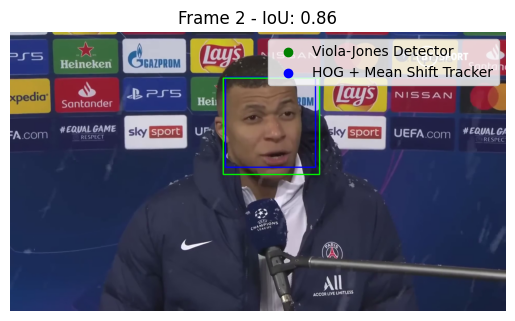

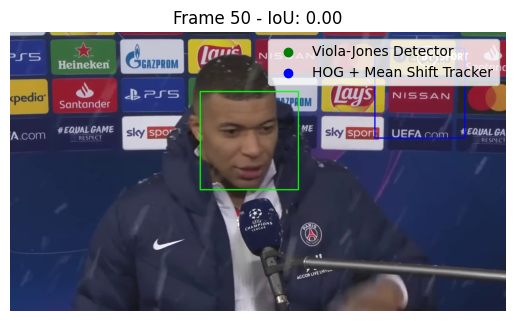

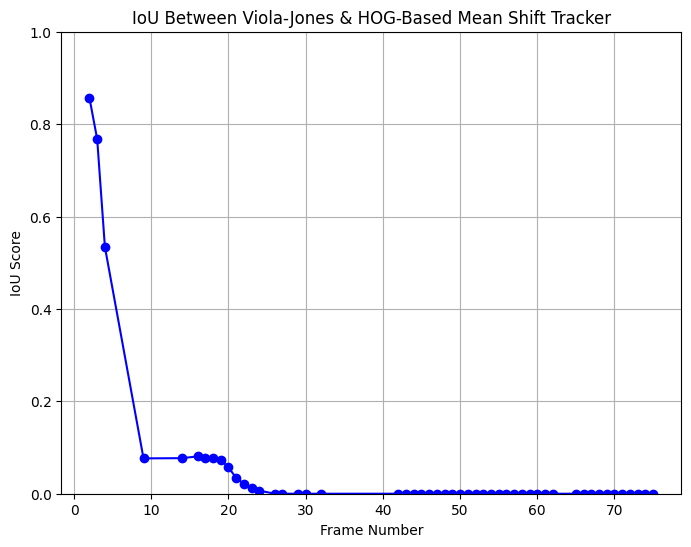

Percentage of frames where IoU > 50%: 4.00%


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_iou(boxA, boxB):
    """Computes Intersection over Union (IoU) between two bounding boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute intersection area
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute individual box areas
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    # Compute IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Load video
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()
if not ret:
    print("Error: Could not read video file.")
    cap.release()
    exit()

# Convert first frame to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect face in first frame using Viola-Jones
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

if len(faces) > 0:
    x, y, w, h = faces[0]  # First detected face
    track_window = (x, y, w, h)  # Initialize tracking window

    # Apply Gaussian Blur
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Compute image gradients using Sobel operator
    grad_x = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=5)

    # Convert gradients to magnitude & direction (in degrees)
    mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    # Extract face region
    face_roi_angle = angle[y:y+h, x:x+w]
    face_roi_mag = mag[y:y+h, x:x+w]

    # Compute frequency-based histogram (no magnitude weighting)
    hist_bins = 24
    hist_range = [0, 360]
    hist = cv2.calcHist([face_roi_angle], [0], None, [hist_bins], hist_range)  # No mask, no magnitude weighting

    # Normalize histogram for tracking
    hist = hist / np.sum(hist)

else:
    print("No face detected in the first frame.")
    cap.release()
    exit()

# Store IoU values
iou_values = []
frame_numbers = []

# Process the rest of the video using Mean Shift Tracking
frame_count = 1

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    frame_count += 1

    # Convert to grayscale and blur
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Compute gradients
    grad_x = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=3)

    # Convert to magnitude and direction
    mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    # Compute back projection using frequency-based HOG histogram
    back_proj = cv2.calcBackProject([angle], [0], hist, [0, 360], 1)

    # Apply Mean Shift to track the face
    ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))

    # Get Viola-Jones detection in the current frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    check = 0

    if len(faces) > 0:
        vx, vy, vw, vh = faces[0]  # Take first detected face
        viola_jones_box = (vx, vy, vw, vh)

        # Compute IoU between Mean Shift and Viola-Jones
        iou = compute_iou(track_window, viola_jones_box)
        iou_values.append(iou)
        frame_numbers.append(frame_count)

        check = 1

    #print(iou_values)

    if frame_count == 50 or frame_count == 2:


        # Draw bounding boxes
        x, y, w, h = track_window
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue box for Mean Shift

        if check == 1:
            cv2.rectangle(frame, (vx, vy), (vx + vw, vy + vh), (0, 255, 0), 3)  # Green box for Viola-Jones

        # Convert BGR to RGB for display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the tracking frame
        plt.imshow(frame_rgb)
        plt.axis("off")
        if check == 1:
          plt.title(f"Frame {frame_count} - IoU: {iou:.2f}")
        else:
          plt.title(f"Frame {frame_count} - IoU: 0")
        # Create legend
        plt.scatter([], [], color='green', label="Viola-Jones Detector")
        plt.scatter([], [], color='blue', label="HOG + Mean Shift Tracker")
        plt.legend()
        plt.pause(0.01)  # Pause for smooth animation

cap.release()
plt.show()

# ** Plot IoU over time **
plt.figure(figsize=(8, 6))
plt.plot(frame_numbers, iou_values, marker="o", linestyle="-", color="b")
plt.xlabel("Frame Number")
plt.ylabel("IoU Score")
plt.title("IoU Between Viola-Jones & HOG-Based Mean Shift Tracker")
plt.ylim(0, 1)
plt.grid()
plt.show()

# ** Print percentage of frames with IoU > 50% **
above_50 = sum(1 for i in iou_values if i > 0.5) / frame_count * 100
print(f"Percentage of frames where IoU > 50%: {above_50:.2f}%")


In [ ]:
# import numpy as np
# import itertools
# import random

# # Always include these indices
# required_indices = [10, 14, 15, 16, 17, 24]  # Corresponding to points 11, 15, 16, 17, 25

# # Define all available indices, excluding the required ones
# all_indices = [0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 22, 23, 25, 26]

# # Randomly sample up to 5 additional indices
# num_extra_points = min(5, len(all_indices))
# random_extra_indices = random.sample(all_indices, num_extra_points)

# # Final selected indices
# selected_indices = required_indices + random_extra_indices

# # Filter points1 and points3 using selected indices
# RW_points4 = points4[selected_indices]
# RW_points5 = points5[selected_indices]

# def compute_translation_magnitude(H):
#     """ Extracts translation components from homography matrix H and computes magnitude. """
#     tx, ty = H[0, 2], H[1, 2]  # Translation components
#     return np.sqrt(tx**2 + ty**2)  # Compute magnitude

# def find_best_point_combination(points1, points3, num_samples=100):
#     """
#     Randomly samples combinations of 5+ points, computes homographies,
#     and returns the combination with the lowest translation magnitude.
#     """
#     best_H = None
#     best_translation = float('inf')
#     best_indices = None

#     num_points = len(points1)

#     # Generate all possible combinations of at least 5 points
#     all_combinations = []
#     for r in range(7, 10):  # Minimum 7 points up to 10
#         all_combinations.extend(itertools.combinations(range(num_points), r))

#     # Randomly sample from the combinations to limit computation
#     sampled_combinations = random.sample(all_combinations, min(num_samples, len(all_combinations)))

#     for indices in sampled_combinations:
#         selected_indices = list(indices)

#         # Filter points based on selected indices
#         filtered_points1 = points1[selected_indices]
#         filtered_points3 = points3[selected_indices]

#         # Compute Homography
#         H2 = compute_H(filtered_points1, filtered_points3, hallway3_gray)

#         # Compute translation magnitude
#         translation_mag = compute_translation_magnitude(H2)

#         print(f"Combo: {indices}")
#         stitch_images(hallway1_gray, hallway3_gray, H2)

#         # Keep track of the best homography with the lowest translation magnitude
#         if translation_mag < best_translation:
#             best_H = H2
#             best_translation = translation_mag
#             best_indices = selected_indices

#     return best_H, best_indices, best_translation

# # Run the optimization process
# H2, best_indices, min_translation = find_best_point_combination(RW_points4, RW_points5)

# # Filter the best points for final homography calculation
# filtered_points1 = RW_points4[best_indices]
# filtered_points3 = RW_points5[best_indices]

# # Compute homography using best subset
# H2 = compute_H(filtered_points1, filtered_points3, hallway3_gray)

# # Stitch the images using the best homography
# stitch_images(hallway1_gray, hallway3_gray, H2)

# # Print best indices and translation magnitude
# print(f"Best point indices: {best_indices}")
# print(f"Minimum translation magnitude: {min_translation}")


# def compute_translation_magnitude(H):
#     """ Extracts translation components from homography matrix H and computes magnitude. """
#     tx, ty = H[0, 2], H[1, 2]  # Translation components
#     return np.sqrt(tx**2 + ty**2)  # Compute magnitude

# def find_best_point_combination(points1, points3, num_samples=100):
#     """
#     Randomly samples combinations of 5+ points, computes homographies,
#     and returns the combination with the lowest translation magnitude.
#     """
#     best_H = None
#     best_translation = float('inf')
#     best_indices = None

#     num_points = len(points1)

#     # Generate all possible combinations of at least 5 points
#     all_combinations = []
#     for r in range(7, 10):  # Minimum 5 points up to all
#         all_combinations.extend(itertools.combinations(range(num_points), r))

#     # Randomly sample from the combinations to limit computation
#     sampled_combinations = random.sample(all_combinations, min(num_samples, len(all_combinations)))

#     for indices in sampled_combinations:
#         selected_indices = list(indices)

#         # Filter points based on selected indices
#         filtered_points1 = points1[selected_indices]
#         filtered_points3 = points3[selected_indices]

#         # Compute Homography
#         H2 = compute_H(filtered_points1, filtered_points3, hallway3_gray)

#         # Compute translation magnitude
#         translation_mag = compute_translation_magnitude(H2)

#         #print(f"Translation: {translationx}")
#         print(f"Combo: {indices}")

#         stitch_images(hallway1_gray, hallway3_gray, H2)

#         # Keep track of the best homography with the lowest translation magnitude
#         if translation_mag < best_translation:
#             best_H = H2
#             best_translation = translation_mag
#             best_indices = selected_indices

#     return best_H, best_indices, best_translation

# # Run the optimization process
# H2, best_indices, min_translation = find_best_point_combination(RW_points4, RW_points5)

# # Filter the best points for final homography calculation
# filtered_points1 = RW_points4[best_indices]
# filtered_points3 = RW_points5[best_indices]

# # Compute homography using best subset
# H2 = compute_H(filtered_points1, filtered_points3, hallway3_gray)

# # Stitch the images using the best homography
# stitch_images(hallway1_gray, hallway3_gray, H2)

# # Print best indices and translation magnitude
# print(f"Best point indices: {best_indices}")
# print(f"Minimum translation magnitude: {min_translation}")


# def compute_reprojection_error(H, points_src, points_dst):
#     """
#     Computes the reprojection error for a given homography matrix H.
#     Measures how well the transformation maps the source points to the destination points.
#     """
#     num_points = points_src.shape[0]

#     # Convert points to homogeneous coordinates
#     points_src_homogeneous = np.hstack([points_src, np.ones((num_points, 1))])

#     # Apply homography
#     transformed_points = H @ points_src_homogeneous.T
#     transformed_points /= transformed_points[2]  # Normalize by homogeneous coordinate

#     # Extract transformed x, y
#     x_transformed, y_transformed = transformed_points[0], transformed_points[1]

#     # Compute Euclidean distance between transformed and actual points
#     errors = np.sqrt((x_transformed - points_dst[:, 0])**2 + (y_transformed - points_dst[:, 1])**2)

#     # Return mean reprojection error
#     return np.mean(errors)

# def find_best_point_combination(points1, points3, num_samples=100):
#     """
#     Randomly samples combinations of 5+ points, computes homographies,
#     and returns the combination with the lowest reprojection error.
#     """
#     best_H = None
#     best_error = float('inf')
#     best_indices = None

#     num_points = len(points1)

#     # Generate all possible combinations of at least 7 points
#     all_combinations = []
#     for r in range(6, 10):  # Minimum 7 points up to all
#         all_combinations.extend(itertools.combinations(range(num_points), r))

#     # Randomly sample from the combinations to limit computation
#     sampled_combinations = random.sample(all_combinations, min(num_samples, len(all_combinations)))

#     for indices in sampled_combinations:
#         selected_indices = list(indices)

#         # Filter points based on selected indices
#         filtered_points1 = points1[selected_indices]
#         filtered_points3 = points3[selected_indices]

#         # Compute Homography
#         H2 = compute_H(filtered_points1, filtered_points3, hallway3_gray)
#         stitch_images(hallway1_gray, hallway3_gray, H2)

#         # Compute reprojection error
#         reproj_error = compute_reprojection_error(H2, filtered_points1, filtered_points3)

#         print(f"Combo: {indices} → Error: {reproj_error:.2f}")

#         # Keep track of the best homography with the lowest reprojection error
#         if reproj_error < best_error:
#             best_H = H2
#             best_error = reproj_error
#             best_indices = selected_indices

#     return best_H, best_indices, best_error

# # Run the optimization process
# H2, best_indices, min_error = find_best_point_combination(RW_points4, RW_points5)

# # Filter the best points for final homography calculation
# filtered_points1 = points4[best_indices]
# filtered_points3 = points5[best_indices]

# # Compute homography using best subset
# H2 = compute_H(filtered_points1, filtered_points3, hallway3_gray)

# # Stitch the images using the best homography
# stitch_images(hallway1_gray, hallway3_gray, H2)

# # Print best indices and reprojection error
# print(f"Best point indices: {best_indices}")
# print(f"Minimum reprojection error: {min_error:.2f}")

import itertools
# import random

# # Number of random samples per r
# num_samples = 10  # Adjust based on how many combinations you want

# # Use all indices from the floor-specific points6 and points7
# total_indices = list(range(len(points6)))  # There are 15 points in each

# # Loop through combinations of 5+ points
# for r in range(6, 10):  # From 5 to 15 points
#     all_combos = list(itertools.combinations(total_indices, r))
#     sampled_combos = random.sample(all_combos, min(num_samples, len(all_combos)))

#     for combo in sampled_combos:
#         filtered_points1 = points6[list(combo)]
#         filtered_points3 = points7[list(combo)]

#         # Compute and visualize homography
#         H2 = compute_H(filtered_points1, filtered_points3, hallway3_gray)
#         print(f"Using indices: {list(combo)}")
#         stitch_images(hallway1_gray, hallway3_gray, H2)

#         # Optional: pause for viewing
#         # input("Press Enter for next combination...")

